# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                      
Sample_058  K7EIS2;K7EKV3;K7EM70;K7EQL9;Q9BSG5;Q9BSG5-2;Q9BSG5-3   16.112
Sample_208  P20916;P20916-2;P20916-3                               15.531
Sample_160  Q9HCB6                                                 16.610
Sample_205  H3BM42;Q92896;Q92896-2;Q92896-3                        15.756
Sample_175  P01717                                                 17.337
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                            
Sample_002  A0A087X117;A0A0G2JN29;J3KN36;P69849;Q15155;Q5JPE7;Q5JPE7-2   15.439
Sample_192  O75752                                                       16.085
Sample_189  P01817                                                       16.208
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.980
            A0A075B6Q5                 13.833
            A0A075B6R2                 12.883
            A0A075B6S5                 13.788
            A0A087WSY4                 13.759
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.974
            Q9UI40;Q9UI40-2            13.198
            Q9UIW2                     14.224
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.470
            Q9UP79                     11.575
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.993,15.050,16.842,19.863,15.617,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.571,19.067,...,15.528,15.576,13.950,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.531,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.102,17.705,17.039,15.630,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.977,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.467,15.345,17.084,18.708,14.249,19.433,11.838,11.192
Sample_207,15.739,16.877,15.469,16.898,15.567,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.364,12.154,13.021,13.025,13.103,13.443,12.637,13.081,13.051,13.217
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.244,19.067,16.127,...,11.975,13.363,12.832,12.223,12.353,13.583,13.327,13.329,12.509,12.065
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.899,12.383,12.095,13.006,12.462,12.611,11.690,13.088,12.643,13.426
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.644,11.850,13.969,12.573,11.624,14.837,11.774,13.194,10.663,12.957
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.027,14.119,11.931,12.905,12.706,12.766,13.558,12.912,12.107,13.801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.885,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 349.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.10it/s]

100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

100%|██████████| 3/3 [00:00<00:00,  6.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.66it/s]

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.24it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.05it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.31it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.06it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.63it/s]

100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.94it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.59it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.66it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.67it/s]

100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.61it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.66it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.37it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.87it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.70it/s]

100%|██████████| 8/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.17it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.46it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.57it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.40it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.85it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.50it/s]

100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.90it/s]

 30%|███       | 3/10 [00:00<00:01,  4.74it/s]

 40%|████      | 4/10 [00:00<00:01,  4.37it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.86it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.01it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.10it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.86it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.90it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.94it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.17it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.39it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.09it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.07it/s]

100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

100%|██████████| 11/11 [00:02<00:00,  5.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.28it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.87it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.80it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.69it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.48it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.38it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.46it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.24it/s]

100%|██████████| 12/12 [00:02<00:00,  3.74it/s]

100%|██████████| 12/12 [00:02<00:00,  4.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.89it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.73it/s]

 31%|███       | 4/13 [00:00<00:01,  4.97it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.67it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.73it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.62it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.62it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.68it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.07it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.10it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.13it/s]

100%|██████████| 13/13 [00:02<00:00,  4.23it/s]

100%|██████████| 13/13 [00:02<00:00,  4.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.25it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.31it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.69it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.38it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.68it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.91it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  4.14it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.25it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.72it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.72it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.84it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

100%|██████████| 14/14 [00:03<00:00,  3.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.02it/s]

 20%|██        | 3/15 [00:00<00:01,  6.54it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.25it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.60it/s]

 40%|████      | 6/15 [00:01<00:02,  3.54it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.40it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.43it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.53it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.28it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.34it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.54it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.63it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.85it/s]

100%|██████████| 15/15 [00:03<00:00,  3.96it/s]

100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.041 0.016          0.785 0.323       0.125   
2             0.004 0.003      0.049 0.018          0.672 0.097       0.570   
3             0.004 0.003      0.055 0.026          0.665 0.111       0.567   
4             0.004 0.003      0.041 0.012          0.676 0.109       0.578   
5             0.004 0.003      0.040 0.012          0.780 0.091       0.800   
6             0.005 0.004      0.057 0.029          0.773 0.091       0.797   
7             0.004 0.002      0.038 0.009          0.780 0.085       0.806   
8             0.006 0.005      0.064 0.028          0.787 0.085       0.806   
9             0.008 0.007      0.066 0.027          0.786 0.086       0.804   
10            0.004 0.001      0.035 0.004          0.793 0.087       0.808   
11            0.003 0.001      0.032 0.007          0.790 0.083       0.806   
12            0.004 0.000      0.036 0.003          0.789 0.082       0.822   
13            0.004 0.002      0.041 0.018          0.790 0.078       0.782   
14            0.006 0.005      0.048 0.017          0.790 0.078       0.783   
15            0.006 0.005      0.047 0.017          0.807 0.078       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.207 0.133                  0.554 0.044        0.856   
2          0.125   0.610 0.094                  0.682 0.067        0.749   
3          0.116   0.606 0.097                  0.677 0.071        0.741   
4          0.123   0.616 0.098                  0.685 0.070        0.741   
5          0.113   0.785 0.081                  0.816 0.069        0.896   
6          0.113   0.780 0.081                  0.811 0.071        0.894   
7          0.110   0.788 0.077                  0.819 0.066        0.893   
8          0.111   0.792 0.075                  0.822 0.064        0.894   
9          0.102   0.790 0.073                  0.820 0.062        0.892   
10         0.115   0.797 0.084                  0.826 0.072        0.908   
11         0.115   0.794 0.080                  0.824 0.069        0.906   
12         0.101   0.801 0.074                  0.829 0.065        0.906   
13         0.109   0.781 0.074                  0.814 0.062        0.908   
14         0.109   0.782 0.075                  0.814 0.063        0.906   
15         0.099   0.799 0.069                  0.829 0.059        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.821 0.085        210.000 0.000  
2          0.071                  0.700 0.087        210.000 0.000  
3          0.073                  0.692 0.091        210.000 0.000  
4          0.069                  0.695 0.084        210.000 0.000  
5          0.051                  0.876 0.056        210.000 0.000  
6          0.050                  0.871 0.056        210.000 0.000  
7          0.051                  0.867 0.057        210.000 0.000  
8          0.049                  0.868 0.056        210.000 0.000  
9          0.051                  0.869 0.057        210.000 0.000  
10         0.050                  0.888 0.058        210.000 0.000  
11         0.051                  0.885 0.061        210.000 0.000  
12         0.052                  0.885 0.060        210.000 0.000  
13         0.050                  0.889 0.061        210.000 0.000  
14         0.051                  0.887 0.061        210.000 0.000  
15         0.049                  0.894 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 505.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.74it/s]

100%|██████████| 2/2 [00:00<00:00,  7.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.32it/s]

100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.86it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.19it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.25it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.30it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.75it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.49it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.80it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.40it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.31it/s]

100%|██████████| 7/7 [00:01<00:00,  3.10it/s]

100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.13it/s]

 38%|███▊      | 3/8 [00:00<00:00,  7.34it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.66it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  5.39it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.65it/s]

100%|██████████| 8/8 [00:01<00:00,  4.23it/s]

100%|██████████| 8/8 [00:01<00:00,  5.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.11it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.65it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.47it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.38it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.32it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.95it/s]

100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.08it/s]

 30%|███       | 3/10 [00:00<00:01,  5.83it/s]

 40%|████      | 4/10 [00:00<00:01,  5.17it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.58it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.28it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.80it/s]

100%|██████████| 10/10 [00:02<00:00,  3.30it/s]

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.12it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.72it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.70it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.41it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.22it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.08it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.94it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.04it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.28it/s]

100%|██████████| 11/11 [00:02<00:00,  3.01it/s]

100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.03it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.47it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.92it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.69it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.46it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.25it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.21it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.46it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.19it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.02it/s]

100%|██████████| 12/12 [00:03<00:00,  2.92it/s]

100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.14it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.61it/s]

 31%|███       | 4/13 [00:00<00:01,  4.82it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.44it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.21it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.21it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.14it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.11it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.06it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.19it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.54it/s]

100%|██████████| 13/13 [00:03<00:00,  3.13it/s]

100%|██████████| 13/13 [00:03<00:00,  3.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.10it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.85it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.31it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.27it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.08it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.05it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.12it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.15it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.10it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.99it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.89it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.38it/s]

100%|██████████| 14/14 [00:03<00:00,  3.01it/s]

100%|██████████| 14/14 [00:03<00:00,  3.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.91it/s]

 20%|██        | 3/15 [00:00<00:02,  4.65it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.47it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.98it/s]

 40%|████      | 6/15 [00:01<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.96it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.13it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.17it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.29it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.39it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.30it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.45it/s]

100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

100%|██████████| 15/15 [00:04<00:00,  3.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.049 0.019          0.000 0.000       0.000   
2             0.004 0.002      0.042 0.014          0.657 0.112       0.468   
3             0.003 0.000      0.039 0.010          0.738 0.088       0.615   
4             0.005 0.004      0.046 0.016          0.745 0.094       0.673   
5             0.004 0.003      0.046 0.015          0.759 0.092       0.689   
6             0.003 0.001      0.043 0.020          0.733 0.099       0.661   
7             0.005 0.004      0.043 0.015          0.730 0.090       0.658   
8             0.005 0.004      0.048 0.018          0.728 0.099       0.677   
9             0.004 0.003      0.047 0.018          0.762 0.095       0.706   
10            0.004 0.002      0.042 0.018          0.810 0.090       0.752   
11            0.004 0.002      0.042 0.015          0.810 0.089       0.751   
12            0.004 0.003      0.040 0.010          0.815 0.086       0.782   
13            0.003 0.001      0.038 0.016          0.820 0.093       0.784   
14            0.004 0.002      0.042 0.014          0.817 0.091       0.784   
15            0.005 0.003      0.049 0.018          0.830 0.082       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.121   0.538 0.104                  0.644 0.061        0.715   
3          0.125   0.664 0.091                  0.727 0.065        0.845   
4          0.128   0.701 0.097                  0.752 0.072        0.851   
5          0.118   0.717 0.090                  0.764 0.069        0.849   
6          0.127   0.689 0.095                  0.741 0.073        0.856   
7          0.124   0.686 0.090                  0.739 0.068        0.855   
8          0.127   0.696 0.095                  0.745 0.076        0.863   
9          0.126   0.727 0.091                  0.771 0.071        0.893   
10         0.107   0.776 0.080                  0.810 0.065        0.908   
11         0.108   0.775 0.079                  0.810 0.065        0.906   
12         0.108   0.793 0.076                  0.824 0.063        0.921   
13         0.114   0.796 0.083                  0.828 0.068        0.922   
14         0.113   0.795 0.082                  0.826 0.067        0.920   
15         0.119   0.811 0.082                  0.840 0.068        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.822 0.087        210.000 0.000  
2          0.068                  0.678 0.083        210.000 0.000  
3          0.059                  0.812 0.071        210.000 0.000  
4          0.056                  0.821 0.065        210.000 0.000  
5          0.058                  0.821 0.068        210.000 0.000  
6          0.057                  0.827 0.068        210.000 0.000  
7          0.056                  0.823 0.067        210.000 0.000  
8          0.059                  0.832 0.071        210.000 0.000  
9          0.051                  0.863 0.066        210.000 0.000  
10         0.048                  0.889 0.056        210.000 0.000  
11         0.048                  0.887 0.056        210.000 0.000  
12         0.044                  0.904 0.051        210.000 0.000  
13         0.045                  0.904 0.052        210.000 0.000  
14         0.045                  0.902 0.052        210.000 0.000  
15         0.043                  0.908 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1169.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.37it/s]

100%|██████████| 3/3 [00:00<00:00, 19.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.74it/s]

100%|██████████| 4/4 [00:00<00:00, 16.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.40it/s]

100%|██████████| 5/5 [00:00<00:00, 18.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.41it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.60it/s]

100%|██████████| 6/6 [00:00<00:00, 14.15it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.37it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.24it/s]

100%|██████████| 7/7 [00:00<00:00, 16.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.01it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.04it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.91it/s]

100%|██████████| 8/8 [00:00<00:00, 14.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.02it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.56it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.34it/s]

100%|██████████| 9/9 [00:00<00:00, 16.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.25it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.29it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.46it/s]

100%|██████████| 10/10 [00:00<00:00, 14.27it/s]

100%|██████████| 10/10 [00:00<00:00, 14.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 24.21it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.47it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.44it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.89it/s]

100%|██████████| 11/11 [00:00<00:00, 15.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 22.81it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.05it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.33it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.46it/s]

100%|██████████| 12/12 [00:00<00:00, 14.06it/s]

100%|██████████| 12/12 [00:00<00:00, 14.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 27.47it/s]

 46%|████▌     | 6/13 [00:00<00:00, 19.07it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 17.39it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 16.90it/s]

100%|██████████| 13/13 [00:00<00:00, 15.80it/s]

100%|██████████| 13/13 [00:00<00:00, 17.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.07it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.17it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 16.84it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 15.40it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.85it/s]

100%|██████████| 14/14 [00:00<00:00, 15.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.99it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.73it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.83it/s]

 60%|██████    | 9/15 [00:00<00:00, 14.03it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.96it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 15.16it/s]

100%|██████████| 15/15 [00:00<00:00, 15.75it/s]

100%|██████████| 15/15 [00:00<00:00, 15.27it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.007          0.000 0.000       0.000   
2             0.006 0.005      0.050 0.017          0.658 0.099       0.468   
3             0.003 0.000      0.036 0.002          0.634 0.121       0.477   
4             0.005 0.005      0.053 0.019          0.647 0.124       0.489   
5             0.003 0.000      0.035 0.004          0.646 0.118       0.514   
6             0.004 0.003      0.049 0.018          0.643 0.111       0.516   
7             0.004 0.002      0.045 0.018          0.630 0.113       0.467   
8             0.004 0.003      0.045 0.015          0.656 0.119       0.485   
9             0.005 0.005      0.052 0.018          0.700 0.104       0.558   
10            0.004 0.002      0.041 0.012          0.697 0.102       0.598   
11            0.004 0.003      0.046 0.015          0.698 0.102       0.593   
12            0.004 0.003      0.036 0.010          0.691 0.077       0.620   
13            0.004 0.003      0.045 0.016          0.684 0.079       0.621   
14            0.005 0.004      0.057 0.021          0.699 0.082       0.637   
15            0.005 0.004      0.053 0.018          0.697 0.083       0.641   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.738   
2          0.101   0.538 0.082                  0.642 0.051        0.691   
3          0.104   0.539 0.095                  0.636 0.067        0.734   
4          0.117   0.550 0.106                  0.645 0.072        0.737   
5          0.112   0.565 0.098                  0.651 0.071        0.752   
6          0.109   0.566 0.093                  0.651 0.067        0.748   
7          0.112   0.528 0.092                  0.630 0.063        0.741   
8          0.103   0.550 0.085                  0.645 0.062        0.744   
9          0.107   0.613 0.081                  0.688 0.057        0.770   
10         0.105   0.636 0.078                  0.700 0.061        0.790   
11         0.107   0.634 0.081                  0.700 0.063        0.786   
12         0.107   0.648 0.077                  0.708 0.059        0.805   
13         0.097   0.646 0.068                  0.704 0.053        0.800   
14         0.092   0.661 0.066                  0.716 0.053        0.806   
15         0.097   0.663 0.068                  0.717 0.055        0.803   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.073                  0.684 0.090        210.000 0.000  
2          0.069                  0.655 0.078        210.000 0.000  
3          0.069                  0.681 0.085        210.000 0.000  
4          0.074                  0.689 0.088        210.000 0.000  
5          0.075                  0.699 0.089        210.000 0.000  
6          0.075                  0.693 0.089        210.000 0.000  
7          0.075                  0.696 0.085        210.000 0.000  
8          0.075                  0.702 0.083        210.000 0.000  
9          0.068                  0.725 0.084        210.000 0.000  
10         0.068                  0.753 0.082        210.000 0.000  
11         0.066                  0.748 0.079        210.000 0.000  
12         0.063                  0.763 0.073        210.000 0.000  
13         0.061                  0.760 0.074        210.000 0.000  
14         0.064                  0.766 0.077        210.000 0.000  
15         0.063                  0.761 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,4,2
score_time,9,1,14
test_precision,15,15,9
test_recall,12,15,15
test_f1,12,15,15
test_balanced_accuracy,12,15,15
test_roc_auc,15,15,14
test_average_precision,15,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.31it/s]

 20%|██        | 3/15 [00:00<00:02,  5.44it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.82it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.55it/s]

 40%|████      | 6/15 [00:01<00:02,  4.38it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.73it/s]

 53%|█████▎    | 8/15 [00:01<00:02,  3.28it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.87it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.92it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.05it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.62it/s]

100%|██████████| 15/15 [00:04<00:00,  2.73it/s]

100%|██████████| 15/15 [00:04<00:00,  3.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.94it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.42it/s]

 50%|█████     | 7/14 [00:00<00:00, 16.08it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 15.49it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.88it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.44it/s]

100%|██████████| 14/14 [00:00<00:00, 14.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.63it/s]

 20%|██        | 3/15 [00:00<00:02,  4.34it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.11it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.95it/s]

 40%|████      | 6/15 [00:01<00:02,  3.56it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.62it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.77it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.90it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.21it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.17it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.19it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.19it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.22it/s]

100%|██████████| 15/15 [00:03<00:00,  4.22it/s]

100%|██████████| 15/15 [00:03<00:00,  4.09it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


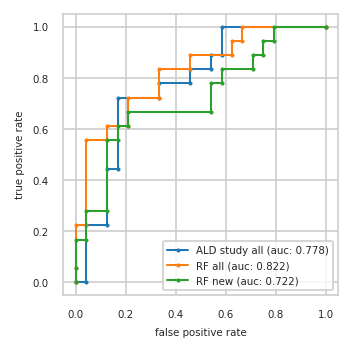

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.222  0.000 0.222  0.000 0.167
3          0.125 0.222  0.042 0.222  0.042 0.167
4          0.125 0.444  0.042 0.556  0.042 0.278
5          0.167 0.444  0.125 0.556  0.125 0.278
6          0.167 0.722  0.125 0.611  0.125 0.556
7          0.333 0.722  0.208 0.611  0.167 0.556
8          0.333 0.778  0.208 0.722  0.167 0.611
9          0.458 0.778  0.333 0.722  0.208 0.611
10         0.458 0.833  0.333 0.833  0.208 0.667
11         0.542 0.833  0.458 0.833  0.542 0.667
12         0.542 0.889  0.458 0.889  0.542 0.778
13         0.583 0.889  0.625 0.889  0.583 0.778
14         0.583 1.000  0.625 0.944  0.583 0.833
15         1.000 1.000  0.667 0.944  0.708 0.833
16           NaN   NaN  0.667 1.000  0.708 0.889
17           NaN   NaN  1.000 1.000  0.750 0.889
18           NaN   NaN    NaN   NaN  0.750 0.944
19           NaN   NaN    NaN   NaN  0.792 0.944
20           NaN   NaN    NaN   NaN  0.792 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,A0A087X136;P51801,A0A0A0MT32;P38571;P38571-2,P01704
2,G3XAI2;P07942,E5RJR5;P63208,P31321
3,P04075,P10636-2;P10636-6,Q96GD0
4,Q99983,P04075,Q504Y2
5,P61981,Q96GD0,Q9UKZ4;Q9UKZ4-2
6,P14174,P61981,A0A075B7B8
7,Q9Y2T3;Q9Y2T3-3,P15151-2,P51688
8,P00338;P00338-3,Q14894,J3KSJ8;Q9UD71;Q9UD71-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


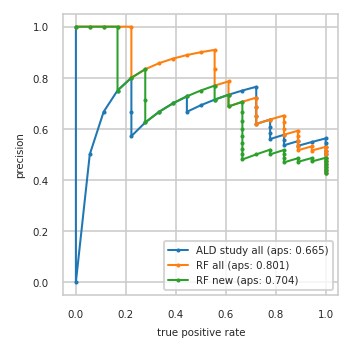

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.548 0.944     0.516 0.889     0.484 0.833
12         0.533 0.889     0.533 0.889     0.500 0.833
13         0.552 0.889     0.552 0.889     0.517 0.833
14         0.536 0.833     0.571 0.889     0.500 0.778
15         0.556 0.833     0.593 0.889     0.519 0.778
16         0.577 0.833     0.577 0.833     0.500 0.722
17         0.560 0.778     0.600 0.833     0.480 0.667
18         0.583 0.778     0.625 0.833     0.500 0.667
19         0.609 0.778     0.652 0.833     0.522 0.667
20         0.636 0.778     0.636 0.778     0.545 0.667
21         0.619 0.722     0.619 0.722     0.571 0.667
22         0.650 0.722     0.650 0.722     0.600 0.667
23         0.684 0.722     0.684 0.722     0.632 0.667
24         0.722 0.722     0.722 0.722     0.667 0.667
25         0.765 0.722     0.706 0.667     0.706 0.667
26         0.750 0.667     0.688 0.611     0.688 0.611
27         0.733 0.611     0.733 0.611     0.733 0.611
28         0.714 0.556     0.786 0.611     0.714 0.556
29         0.692 0.500     0.769 0.556     0.769 0.556
30         0.667 0.444     0.833 0.556     0.750 0.500
31         0.727 0.444     0.909 0.556     0.727 0.444
32         0.700 0.389     0.900 0.500     0.700 0.389
33         0.667 0.333     0.889 0.444     0.667 0.333
34         0.625 0.278     0.875 0.389     0.625 0.278
35         0.571 0.222     0.857 0.333     0.714 0.278
36         0.667 0.222     0.833 0.278     0.833 0.278
37         0.800 0.222     0.800 0.222     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


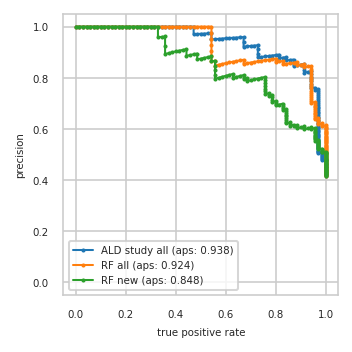

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


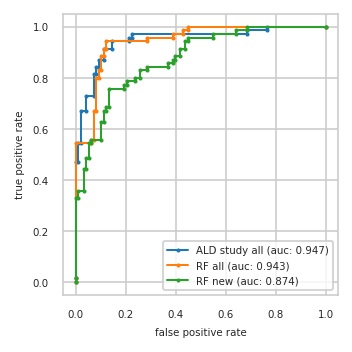

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}